###Import the Library First

In [1]:
import os
import re
import requests
import zipfile
import io
import codecs
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, LSTM, Bidirectional
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

###Load Dataset from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Chatbot LSTM/Model Final/kamusdata.txt'

###Preprocessing Dataset
The main objective of this step is to ensure that the data fits into the Bi-LSTM and Seq2Seq architecture.

In [14]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def get_all_conversations(path):
    all_conversations = []
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            question, answer = line.strip().split('\t')
            all_conversations.append((question, answer))
    return all_conversations

def clean_text(text_to_clean):
    # Remove punctuation except for apostrophes
    text = re.sub(r'(?<![a-zA-Z\d])\'|\'(?![a-zA-Z\d])|[^\w\s\d\']+', '', text_to_clean.lower())
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    cleaned_text = ' '.join(lemmatized_words)
    return cleaned_text

def get_clean_q_and_a(conversations):
    ctx_and_target = []
    for question, answer in conversations:
        cleaned_question = clean_text(question)
        cleaned_answer = '<START> ' + clean_text(answer) + ' <END>'
        ctx_and_target.append((cleaned_question, cleaned_answer))
    context, target = zip(*ctx_and_target)
    return list(context), list(target)

# Get all conversations from the file
all_conversations = get_all_conversations(path)

# Clean questions and answers and add <START> and <END> tokens
cleaned_questions, cleaned_answers = get_clean_q_and_a(all_conversations)

# Print the results
print("Cleaned Questions:", cleaned_questions[10:])
print("Cleaned Answers:", cleaned_answers[10:])


Cleaned Questions: ['malam', 'selamat sore', 'sore', 'hai apa kabar', 'kabar saya baik', 'apakah anda merasa sehat', 'apakah kamu sakit', 'bagaimana kabar mu hari ini', 'apakah kamu pernah merasakan lelah', 'kamu ini apa', 'informasi apa saja yang bisa anda bagikan', 'saya cukup lelah hari ini', 'apakah kamu memiliki nama', 'saya juga bingung ingin memberikan saran apa', 'bagaimana kabar anda hari ini', 'apa yang sedang anda lakukan', 'apa yang sedang anda lakukan', 'apakah kamu dapat berpikir seperti manusia', 'tahukah anda bagaimana cara mendaftar seminar proposal', 'bagaimana cara mendaftar seminar proposal mahasiswa', 'cara daftar seminar', 'cara daftar seminar proposal', 'saya ingin tahu bagaimana cara daftar sempro', 'cara daftar sempro', 'bagaimana cara daftar sempro', 'tunjukkan caranya', 'bagaimana caranya', 'apa saja tahapan untuk daftar sempro', 'bagaimana langkah daftar sempro', 'prosedur daftar seminar proposal', 'saya ingin daftar sempro bagaimana caranya', 'bagaimana pro

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
#Let see if the question and answer was clean


import pandas as pd

# Create a DataFrame with the cleaned questions and answers
df = pd.DataFrame({'Cleaned Questions': cleaned_questions, 'Cleaned Answer': cleaned_answers})

# Print the DataFrame
print(df)


                                      Cleaned Questions  \
0                                                  halo   
1                                                   hai   
2                                          selamat pagi   
3                                       assalamualaikum   
4                                          selamat pagi   
...                                                 ...   
1247  syarat apa saja yang harus dipenuhi untuk veri...   
1248  dokumen apa saja yang dibutuhkan untuk verifik...   
1249  apa saja yang diperlukan untuk verifikasi dan ...   
1250  apa dokumen yang harus disiapkan untuk verifik...   
1251  apa saja persyaratan yang perlu dipenuhi untuk...   

                                         Cleaned Answer  
0           <START> halo apa yang bisa saya bantu <END>  
1              <START> hai kamu butuh bantuan apa <END>  
2     <START> selamat pagi apa yang bisa saya lakuka...  
3                          <START> waalaikumsalam <END>  
4

In [16]:
#save dataset into csv file
df.to_csv("df.csv")

###Random Shuffle Dataset
Purpose of this step is to make sure the dataset was shuffled correctly. Unshuffled dataset causes low accuracy and overfitting because the model can't learn effectively.

In [17]:
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences

# combined the data first
combined_data = list(zip(cleaned_questions, cleaned_answers))
random.shuffle(combined_data)

shuffled_questions, shuffled_answers = zip(*combined_data)

In [18]:
# Let's check the results

# Contoh data sebelum pengacakan
print("Data Pertanyaan Sebelum Pengacakan:")
for i in range(20):
    print(cleaned_questions[i])

print("\nData Jawaban Sebelum Pengacakan:")
for i in range(20):
    print(cleaned_answers[i])

# Contoh data setelah pengacakan
print("\nData Pertanyaan Setelah Pengacakan:")
for i in range(20):
    print(shuffled_questions[i])

print("\nData Jawaban Setelah Pengacakan:")
for i in range(20):
    print(shuffled_answers[i])

Data Pertanyaan Sebelum Pengacakan:
halo
hai
selamat pagi
assalamualaikum
selamat pagi
pagi
selamat siang
selamat siang
siang
selamat malam
malam
selamat sore
sore
hai apa kabar
kabar saya baik
apakah anda merasa sehat
apakah kamu sakit
bagaimana kabar mu hari ini
apakah kamu pernah merasakan lelah
kamu ini apa

Data Jawaban Sebelum Pengacakan:
<START> halo apa yang bisa saya bantu <END>
<START> hai kamu butuh bantuan apa <END>
<START> selamat pagi apa yang bisa saya lakukan untuk anda <END>
<START> waalaikumsalam <END>
<START> halo ini adalah fsthelpbot chatbot informasi akademik fakultas sains dan teknologi <END>
<START> selamat pagi apa yang bisa saya lakukan untuk anda <END>
<START> selamat siang apa yang bisa saya lakukan untuk anda <END>
<START> selamat datang bagaimana saya bisa membantu anda <END>
<START> halo ini adalah fsthelpbot chatbot informasi akademik fakultas sains dan teknologi <END>
<START> selamat malam bagaimana saya bisa membantu anda <END>
<START> halo selamat dat

In [19]:
print(f'Total conversations in dataset: {len(all_conversations)}')

Total conversations in dataset: 1252


###Data Restructuring for Encoder and Decoder Layer

In [20]:

#Import tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(shuffled_questions + shuffled_answers)

VOCAB_SIZE = len(tokenizer.word_index) + 1


#Crate Encoder Input Data
tokenized_questions = tokenizer.texts_to_sequences(shuffled_questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
encoder_input_data = pad_sequences(tokenized_questions, maxlen=maxlen_questions, padding='post')

#Create Decoder Input Data
tokenized_answers = tokenizer.texts_to_sequences(shuffled_answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
decoder_input_data = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')

#Create Decoder Output Data
for i in range(len(tokenized_answers)):
  tokenized_answers[i] = tokenized_answers[i][1:]

decoder_output_data = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding=
                                 'post')


print(f'Vocab Size: {VOCAB_SIZE}')

Vocab Size: 1352


In [21]:
#save tokenizer into pickle

import pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

print("Tokenizer berhasil disimpan dalam file tokenizer.pkl")

Tokenizer berhasil disimpan dalam file tokenizer.pkl


### Create Bi-LSTM Model
While the preprocessing was done, the next step is the modeling phase. This step utilizes sequence-to-sequence and Bi-LSTM networks

In [22]:
from tensorflow.keras.layers import Dropout

HIDDEN_DIM = 100
def build_bi_lstm(dropout_rate=0.2):

    # encoder layer
    enc_inputs = Input(shape=(None,))
    enc_embedding = Embedding(VOCAB_SIZE, 128, mask_zero=True)(enc_inputs)
    enc_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(HIDDEN_DIM, return_state=True))(enc_embedding)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    enc_states = [state_h, state_c]

    # dropout layer
    dropout_layer = Dropout(rate=dropout_rate)

    # decoder layer
    dec_inputs = Input(shape=(None,))
    dec_embedding = Embedding(VOCAB_SIZE, 128, mask_zero=True)(dec_inputs)
    dec_lstm = LSTM(HIDDEN_DIM * 2, return_state=True, return_sequences=True)
    dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
    dec_outputs_dropout = dropout_layer(dec_outputs)  # Adding dropout layer
    dec_dense = Dense(VOCAB_SIZE, activation='softmax')
    output = dec_dense(dec_outputs)
    bi_lstm = Model([enc_inputs, dec_inputs], output)
    return bi_lstm, enc_inputs, enc_states, dec_inputs, dec_embedding, dec_lstm, dec_dense

# summary of the model
model = build_bi_lstm()
bi_lstm = model[0]
bi_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 128)            173056    ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 200),                183200    ['embedding[0][0]']           
 al)                          (None, 100),                                                    

In [23]:
#Train the model


EPOCHS = 500
bi_lstm_all = []
bi_lstm_acc = []
batch_sizes = [16]
for batch_size in batch_sizes:
    print(f'\nCurrent batch size: {batch_size}')
    model = build_bi_lstm()
    bi_lstm = model[0]
    bi_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = bi_lstm.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=EPOCHS, batch_size=batch_size, validation_split=0.1)
    bi_lstm.save_weights(f'./bi_lstm_{batch_size}.h5')
    acc = history.history.get('accuracy')
    bi_lstm_all.append(acc)
    print(f'Training accuracy {"{:.2%}".format(acc[-1])}')
    bi_lstm_acc.append(acc[-1])

print('\nTraining completed!\n')


Current batch size: 16
Epoch 1/500
71/71 [==============================] - 28s 180ms/step - loss: 5.1131 - accuracy: 0.1252 - val_loss: 3.5604 - val_accuracy: 0.3366
Epoch 2/500
71/71 [==============================] - 6s 79ms/step - loss: 2.5100 - accuracy: 0.5062 - val_loss: 1.7001 - val_accuracy: 0.6680
Epoch 3/500
71/71 [==============================] - 5s 72ms/step - loss: 1.3516 - accuracy: 0.7166 - val_loss: 1.2129 - val_accuracy: 0.7711
Epoch 4/500
71/71 [==============================] - 3s 42ms/step - loss: 0.9073 - accuracy: 0.8004 - val_loss: 1.0464 - val_accuracy: 0.8012
Epoch 5/500
71/71 [==============================] - 3s 37ms/step - loss: 0.6806 - accuracy: 0.8421 - val_loss: 0.9544 - val_accuracy: 0.8276
Epoch 6/500
71/71 [==============================] - 2s 29ms/step - loss: 0.5267 - accuracy: 0.8717 - val_loss: 0.9023 - val_accuracy: 0.8392
Epoch 7/500
71/71 [==============================] - 4s 57ms/step - loss: 0.4158 - accuracy: 0.8945 - val_loss: 0.8781 - v

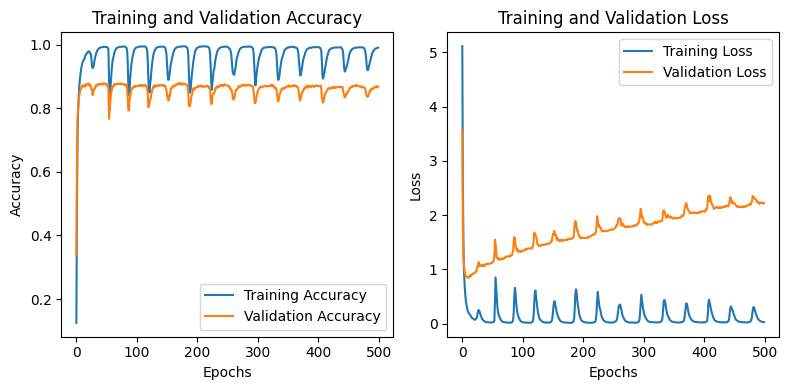

In [24]:
plt.figure(figsize=(8, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()

# Simpan gambar
plt.savefig('training_plot.png')
plt.show()

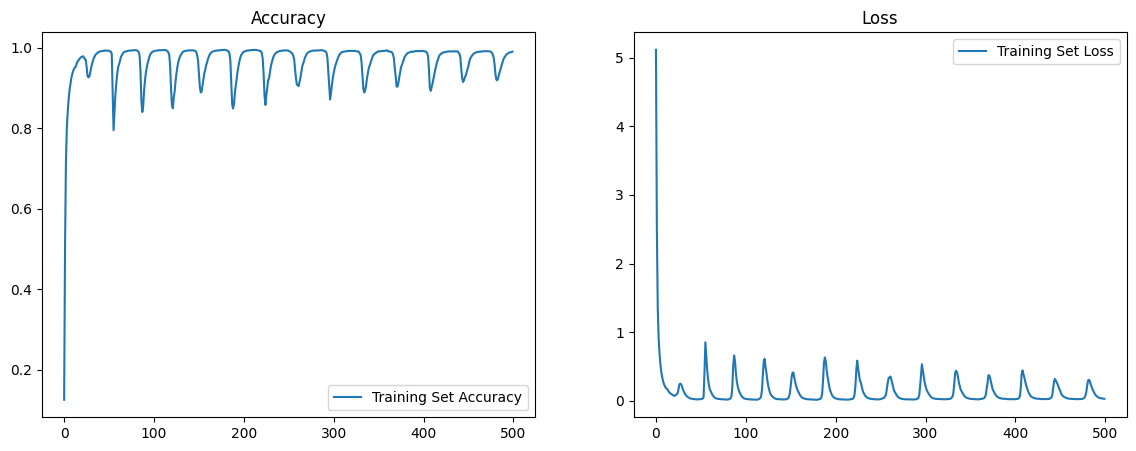

In [25]:
#accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')


# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

###Create Inference Model to Interact with Bot

In [27]:
# Define the functions to create encoder and decoder models
def make_inference_models():
    # Load bidirectional LSTM model with the best batch size
    bi_lstm, enc_inputs, enc_states, dec_inputs, dec_embedding, dec_lstm, dec_dense = build_bi_lstm()
    batch_size = batch_sizes[np.argmax(bi_lstm_acc)]
    bi_lstm.load_weights(f'./bi_lstm_{batch_size}.h5')

    # Decoder model
    dec_state_input_h = Input(shape=(HIDDEN_DIM * 2,))
    dec_state_input_c = Input(shape=(HIDDEN_DIM * 2,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding, initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(inputs=[dec_inputs] + dec_states_inputs, outputs=[dec_outputs] + dec_states)

    # Encoder model
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
    return enc_model, dec_model

# Function to convert string to tokens
def str_to_tokens(sentence: str):
    words = sentence.lower().split()
    tokens_list = []
    for current_word in words:
        result = tokenizer.word_index.get(current_word, '')
        if result != '':
            tokens_list.append(result)
    return pad_sequences([tokens_list], maxlen=maxlen_questions, padding='post')

# Create encoder and decoder models
encoder_model, decoder_model = make_inference_models()

# Interact with the chatbot
while True:
    # Take user input
    input_text = input('You: ')
    if input_text == 'exit':
        break

    # Encode the input sequence into state vectors
    states_values = encoder_model.predict(str_to_tokens(input_text))

    # Initialize target sequence with 'start' token
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']

    # Initialize variables for decoding loop
    stop_condition = False
    decoded_translation = ''

    while not stop_condition:
        # Predict next word
        dec_outputs, h, c = decoder_model.predict([empty_target_seq] + states_values)
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])

        # Get sampled word
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != 'end':
                    decoded_translation += f'{word} '
                sampled_word = word

        # Check stop condition
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True

        # Prepare for next iteration
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]

    # Output chatbot response
    print('Chatbot: ' + decoded_translation)


You: exit


###Save the model into h.5 format

In [28]:
# Simpan encoder model ke dalam file terpisah
encoder_model.save('encoder_model.h5')

# Simpan decoder model ke dalam file terpisah
decoder_model.save('decoder_model.h5')

### Chatbot evaluation using Bilingual Evaluation Understudy (BLEU)
This step measures how good the chatbot's performance is on a numeric scale. BLEU will compare the chatbot's output with human translation.

In [29]:
from nltk.translate.bleu_score import sentence_bleu

# Interaksi dengan chatbot
while True:
    # Get user input
    input_text = input('You: ')

    # Exit condition
    if input_text.lower() == 'exit':
        break

    # Get expected answer from the user
    reference_answer = input("Expected Answer: ")

    # Preprocess the expected answer
    reference_answer = clean_text(reference_answer)
    reference_answer = '<START> ' + reference_answer + ' <END>'

    # Encode the input sequence into state vectors
    states_values = encoder_model.predict(str_to_tokens(input_text))

    # Initialize variables for decoding
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    decoded_translation = ''

    # Decode until the stop condition is met
    for _ in range(maxlen_answers):
        dec_outputs, h, c = decoder_model.predict([empty_target_seq] + states_values)
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_word_index, '')

        if sampled_word == 'end':
            break

        if sampled_word:
            decoded_translation += sampled_word + ' '

        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]

    # Clean up the decoded translation
    decoded_translation = decoded_translation.strip()

    # Calculate BLEU score
    bleu_score = sentence_bleu([reference_answer.split()], decoded_translation.split())

    # Print chatbot response and BLEU score
    print('Chatbot:', decoded_translation)
    print('BLEU Score:', bleu_score)


You: Selamat pagi
Expected Answer: selamat pagi! apa yang bisa saya lakukan untuk anda
1/1 [==============================] - 0s 27ms/step
Chatbot: halo ini adalah fsthelpbot chatbot informasi akademik fakultas sains dan teknologi
BLEU Score: 0
You: apa saja tahapan untuk daftar sempro
Expected Answer: Langkah yang harus kamu lakukan adalah: Pertama, menyiapkan berkas persyaratan untuk mengajukan seminar/sidang. Kedua, menyerahkan berkas kepada program studi mahasiswa. Selanjutnya melakukan pendaftaran mandiri melalui website seminar-fst.uin-suska.ac.id
1/1 [==============================] - 0s 20ms/step
Chatbot: langkah yang harus kamu lakukan adalah pertama menyiapkan berkas persyaratan untuk mengajukan seminarsidang kedua menyerahkan berkas kepada program studi mahasiswa selanjutnya melakukan pendaftaran mandiri melalui website seminarfstuinsuskaacid
BLEU Score: 0.9286029058931802
You: exit


###This for Calulaction BLEU Score for entire dataset

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Membersihkan pertanyaan dan jawaban dari dataset
cleaned_questions, cleaned_answers = get_clean_q_and_a(all_conversations)

# Memprediksi jawaban dari pertanyaan-pertanyaan dalam dataset
predicted_answers = []
for question in cleaned_questions:
    states_values = encoder_model.predict(str_to_tokens(question))
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition:
        dec_outputs, h, c = decoder_model.predict([empty_target_seq] + states_values)
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != 'end':
                    decoded_translation += f'{word} '
                sampled_word = word
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]
    predicted_answers.append(decoded_translation.strip().split())

# Hitung BLEU score untuk seluruh dataset
reference_answers = [[answer.split()] for answer in cleaned_answers]
bleu_score = corpus_bleu(reference_answers, predicted_answers)

print('BLEU Score for the Entire Dataset:', bleu_score)

In [30]:
import pandas as pd
pd.show_versions(as_json=False)


INSTALLED VERSIONS
------------------
commit           : 0f437949513225922d851e9581723d82120684a6
python           : 3.10.12.final.0
python-bits      : 64
OS               : Linux
OS-release       : 6.1.85+
Version          : #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 2.0.3
numpy            : 1.25.2
pytz             : 2023.4
dateutil         : 2.8.2
setuptools       : 67.7.2
pip              : 23.1.2
Cython           : 3.0.10
pytest           : 7.4.4
hypothesis       : None
sphinx           : 5.0.2
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.9.4
html5lib         : 1.1
pymysql          : None
psycopg2         : 2.9.9
jinja2           : 3.1.4
IPython          : 7.34.0
pandas_datareader: 0.10.0
bs4              : 4.12.3
bottleneck       : None